In [ ]:
# Full example using charuco images to calibrate the distortion and focal length
# from the video file from a camera, and also use to calculate the pose estimations

# Stuff to do: resample the parameters so that they are aligned and can find the rotation optimally


# move more code into hacktrack.video with more documentation there
# reproduce with device on a pendulum
# code hanglog3 to give me the orientation calibration
# code the hanglog3 to record named photo frames with the log to all-in-one check with its orientation
# check orientations in phone agree with device
# make wooden 3*3 charuco board


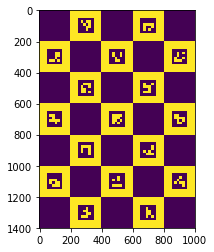

In [3]:
#
# Use this to generate a charuco image for you
#
import cv2
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
squaresX, squaresY = 5, 7
markersquareratio = 0.5
charboard = cv2.aruco.CharucoBoard_create(squaresX, squaresY, 0.025, 0.025*markersquareratio, aruco_dict)
img = charboard.draw((200*5, 200*7))
cv2.imwrite('charuco.png',img)

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img)

In [2]:
#
# Use this cell to find chessboards and calculate the camera distortion
#
import cv2

import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")
from hacktrack import videos

vdir = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/"
vfile = vdir+"turnigy_charuco.MOV"
vfile = vdir+"turnigy_charuco5.MOV"
cap = cv2.VideoCapture(vfile)

cameraMatrix, distCoeffs = videos.cameramatrixfromchessboards(cap, sframes=44, squaresX=5, squaresY=7, chesssquareLength=0.0573)
print("cameraMatrix = numpy.%s" % repr(cameraMatrix))
print("distCoeffs = numpy.%s" % repr(distCoeffs))



nframes 1952 w,h = (1920, 1080)
calculating camera coeffs for 26 chessboards
cameraMatrix = numpy.array([[1.03181843e+03, 0.00000000e+00, 9.59401839e+02],
       [0.00000000e+00, 1.04312843e+03, 5.64199756e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.33886976,  0.17074518,  0.00066423,  0.00192652, -0.05255663]])


In [1]:
# 
# Use this cell to preview frames through the undistortion lens
#
import cv2, numpy
import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")
from hacktrack import videos

vdir = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/"
vfile = vdir+"turnigy_charuco5.MOV"

cameraMatrix = numpy.array([[1.01048336e+03, 0.00000000e+00, 9.46630412e+02],
                            [0.00000000e+00, 1.01945395e+03, 5.71135893e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.31967893,  0.13367133, -0.00175612,  0.00153122, -0.03052692]])

from matplotlib import pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture(vfile)
videos.frameundistortdetectinteractive(cap, cameraMatrix, distCoeffs, squaresX=5, squaresY=7, markersquareratio=0.5, chesssquareLength=0.0573)


Output(layout=Layout(height='400px'))

nframes 1702 w,h = (1920, 1080)
500
1000
1500


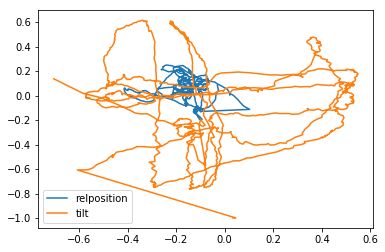

In [40]:
#
# Use this cell to extract the pose position (tilt and translate) from each frame where there is a charuco board
#
import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")
from hacktrack import videos

import numpy, cv2
vdir = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/"
vfile = vdir+"turnigy_charuco4.MOV"
cap = cv2.VideoCapture(vfile)

cameraMatrix = numpy.array([[1.01048336e+03, 0.00000000e+00, 9.46630412e+02],
                            [0.00000000e+00, 1.01945395e+03, 5.71135893e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.31967893,  0.13367133, -0.00175612,  0.00153122, -0.03052692]])


tiltv = videos.findtiltfromvideoframes(cap, cameraMatrix, distCoeffs, squaresX=5, squaresY=7, chesssquareLength=0.0573, markersquareratio=0.5)
len(tiltv)


from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(tiltv.tx, tiltv.ty, label="relposition")
plt.plot(tiltv.rx, tiltv.ry, label="tilt")
plt.legend()

In [30]:
# 
# The next cells from here on are about loading the corresponding logfile with the orientation sensor
# and aligning it timewise with the flashing LED
# and comparing it to the tilt axis from the accelerometer sensor
#

import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")

from hacktrack import loaders, clickables, utils
import pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
vdir = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/"
logfile = vdir+"hdata-turnigy_charuco4.log"
fd = loaders.FlyDat(logfile)
fd.LoadC("U")
fd.LoadC("Z")

# convert quaternions into tilt of Z-axis
pZ = fd.pZ
r00 = pZ.q0*pZ.q0*2 * pZ.iqsq
r33 = pZ.q3*pZ.q3*2 * pZ.iqsq
r01 = pZ.q0*pZ.q1*2 * pZ.iqsq
r02 = pZ.q0*pZ.q2*2 * pZ.iqsq
r13 = pZ.q1*pZ.q3*2 * pZ.iqsq
r23 = pZ.q2*pZ.q3*2 * pZ.iqsq
pZ["tiltx"] = r13 + r02
pZ["tilty"] = r23 - r01
pZ["tiltz"] = r00 - 1 + r33


should be same None 2019-07-26 00:00:00
badline End(9165,805)

F:3563, Z:5585, U:17, aZ:402, aF:402
linAdifftime 10751197.054945055 count 364
Made for Q 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Missing GPS data, so setting t0 to 2019-07-26 14:57:00.454055
Made for U 17 last index 17
Warning, using guessed (not GPS) timing corrected value on U 17
pCattrname pU
BAD VALUES 143 [(5, 'Zt000220AEx6F12y4BD6zF32Ba0B0Bb0000c1300w12BBxD66FyBB4BzBB16s8E\n'), (7, 'Zt000220E2xBB10yBB16z6C12a4BD6bEC2Bc100Bw12BBxD66Cy2B4Bz0BECs01\n'), (45, 'Zt000222AEx0003y0003zBB0CaD916b8612c5FD6w12D9xD686y2B5Fz0BCAsCA\n')]
Made for Z 5585 last index 5442
Warning, using guessed (not GPS) timing corrected value on Z 5585
pCattrname pZ


1

In [31]:
#
# Use this cell to calculate the flashing LED times for logfile alignment
#
vdir = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/"
vfile = vdir+"turnigy_charuco4.MOV"

import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")

import cv2, numpy, pandas
cap = cv2.VideoCapture(vfile)

from hacktrack import videos


# interactively select the range
videos.frameselectinteractive(cap, cameraMatrix, distCoeffs)

# cache the values to get there directly
#videos.Wledxselrange.value = (1128, 1254)
#videos.Wledyselrange.value = (772, 946)


Output(layout=Layout(height='400px'))

scanning between frames (1, 1702)
1000


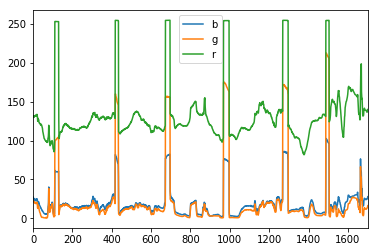

In [32]:
ledbrights = videos.extractledflashframes(cap)
ledbrights.plot()

[(0.528680830376796, -5, 2), (0.2330213334444502, -4, 3), (0.2646202576021953, -3, 4), (0.36452893647177287, -2, 4), (0.0007227994508315627, -1, 4), (0.2808150428920465, 0, 4), (0.22026633327172562, 1, 3), (0.14126571700287205, 2, 2)]
(0.0007227994508315627, -1, 4)
Framerate 30.01719390495441
LinregressResult(slope=0.03331423993749621, intercept=-22.41700681127708, rvalue=0.9999998928497611, pvalue=1.0715023890385147e-07, stderr=1.0905021247596254e-05)


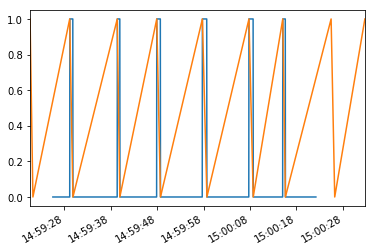

In [39]:
import scipy.stats
videoledonvalues = ledbrights.r>200
ledswitchtimes = (fd.pU.Dust==1)  # one timestamped record for every on and off of the LED
#frametimes = videos.framestotime(videoledonvalues, ledswitchtimes)
frametimes = framestotime(videoledonvalues, ledswitchtimes)

plt.plot(frametimes[videoledonvalues.index], videoledonvalues)
(ledswitchtimes*1).plot()


In [41]:
# Convert the tilts from video into time series
assert "framenum" not in tiltv.columns
tiltv["frametime"] = frametimes
tiltv["framenum"] = tiltv.index.to_series()
tiltv.set_index("frametime", inplace=True)
tiltv.index.name = None


In [42]:
# This cell to try and work out the single rotation that will register between the camera 
# orientation of Z tiltv.r[xyz] to the accelerometer orientation of Z

# overlapping time range
t0, t1 = max(tiltv.index[10], fd.pZ.index[10]), min(tiltv.index[-10], fd.pZ.index[-10])
lpZ = pZ[t0:t1]

# kingpost vectors from camera and orientation sensors interpolated in time
rx, ry, rz = tiltv.rx[t0:t1], tiltv.ry[t0:t1], tiltv.rz[t0:t1]
ax = utils.InterpT(rx, lpZ.tiltx)
ay = utils.InterpT(ry, lpZ.tilty)
az = utils.InterpT(rz, lpZ.tiltz)

# Find the rotation between these two sets of points using SVD technology
# a[xyz] * r[xyz]^T
H = numpy.array([[sum(ax*rx), sum(ax*ry), sum(ax*rz)], 
                 [sum(ay*rx), sum(ay*ry), sum(ay*rz)], 
                 [sum(az*rx), sum(az*ry), sum(az*rz)]])
U, S, Vt = numpy.linalg.svd(H)
R = numpy.matmul(U, Vt)

print("Rotations in XYZ come to", numpy.degrees(cv2.Rodrigues(R)[0].reshape(3)), "degrees")

# Apply the rotations to the camera orientation
rrx, rry, rrz = \
(R[0][0]*rx + R[0][1]*ry + R[0][2]*rz, 
 R[1][0]*rx + R[1][1]*ry + R[1][2]*rz,
 R[2][0]*rx + R[2][1]*ry + R[2][2]*rz)


Rotations in XYZ come to [  0.52880368   0.96020647 -80.29792978] degrees


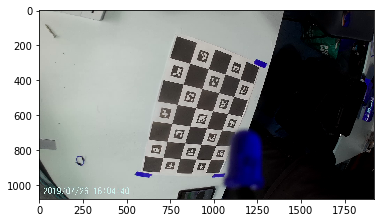

In [43]:
cap.set(cv2.CAP_PROP_POS_FRAMES, 1028)
flag, frame = cap.retrieve()
plt.imshow(frame)

In [40]:
#plt.plot(rrx.iloc[950:965])
tiltv[965:975]

,rx,ry,rz,tx,ty,tz,framenum
2019-07-26 12:11:26.949268,-0.413482,0.184685,-0.891585,0.289127,0.534865,0.397395,1018
2019-07-26 12:11:26.982604,-0.443387,0.191480,-0.875639,0.305227,0.529777,0.398408,1019
2019-07-26 12:11:27.015940,-0.468399,0.213036,-0.857449,0.319120,0.525823,0.391062,1020
2019-07-26 12:11:27.049276,-0.685632,0.723093,0.083930,0.089748,0.383883,0.289278,1021
2019-07-26 12:11:27.082612,-0.279423,-0.178465,-0.943437,0.385745,0.527023,0.550628,1022
2019-07-26 12:11:27.115948,-0.711173,0.686754,0.150341,0.075304,0.355064,0.296728,1023
2019-07-26 12:11:27.149284,-0.542317,0.734425,-0.408060,0.184200,0.432630,0.217433,1024
2019-07-26 12:11:27.182620,-0.484393,0.169768,-0.858220,0.374968,0.509860,0.398589,1025
2019-07-26 12:11:27.215956,-0.480655,0.150906,-0.863828,0.379306,0.506821,0.401247,1026
2019-07-26 12:11:27.249292,-0.476057,0.133112,-0.869282,0.378854,0.503346,0.404970,1027


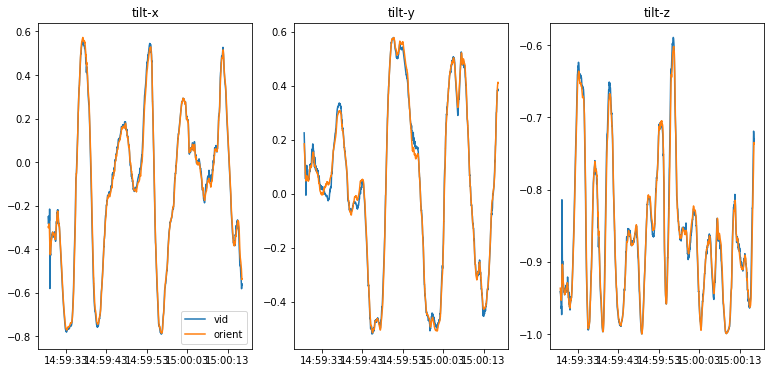

In [65]:
plt.figure(figsize=(13,6))
plt.subplot(1,3,1)
plt.title("tilt-x")
plt.plot(rrx, label="vid")
plt.plot(lpZ.tiltx, label="orient")
plt.legend()
plt.subplot(1,3,2)
plt.title("tilt-y")
plt.plot(rry)
plt.plot(lpZ.tilty)
plt.subplot(1,3,3)
plt.title("tilt-z")
plt.plot(rrz)
plt.plot(lpZ.tiltz)

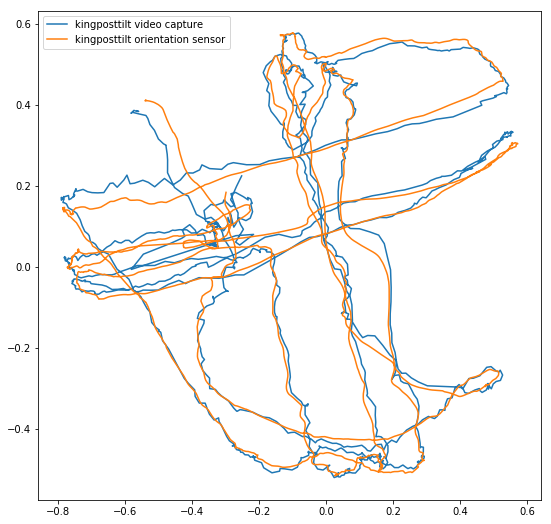

In [62]:
plt.figure(figsize=(9,9))
plt.plot(rrx, rry, label="kingposttilt video capture")
plt.plot(lpZ.tiltx, lpZ.tilty, label="kingposttilt orientation sensor")
plt.legend()

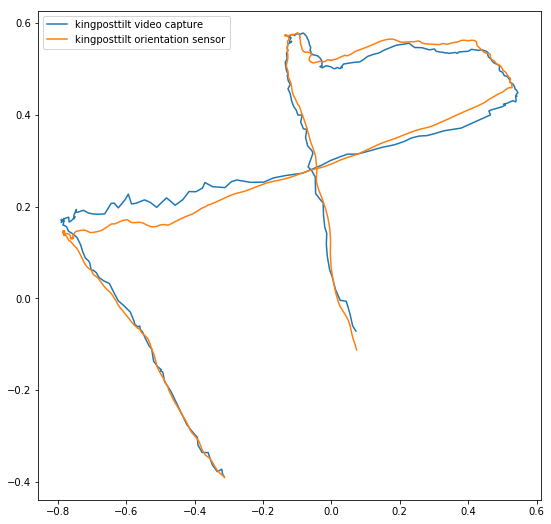

In [63]:
ft0, ft1 = t0+pandas.Timedelta(seconds=20), t0+pandas.Timedelta(seconds=30)
plt.figure(figsize=(9,9))
plt.plot(rrx[ft0:ft1], rry[ft0:ft1], label="kingposttilt video capture")
plt.plot(lpZ.tiltx[ft0:ft1], lpZ.tilty[ft0:ft1], label="kingposttilt orientation sensor")
plt.legend()

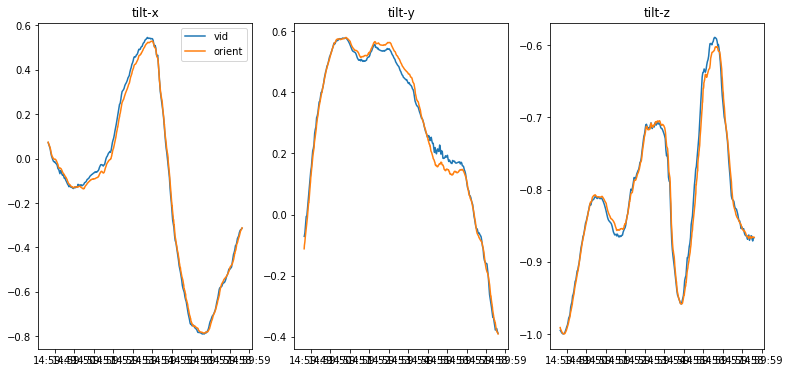

In [64]:
plt.figure(figsize=(13,6))
plt.subplot(1,3,1)
plt.title("tilt-x")
plt.plot(rrx[ft0:ft1], label="vid")
plt.plot(lpZ.tiltx[ft0:ft1], label="orient")
plt.legend()
plt.subplot(1,3,2)
plt.title("tilt-y")
plt.plot(rry[ft0:ft1])
plt.plot(lpZ.tilty[ft0:ft1])
plt.subplot(1,3,3)
plt.title("tilt-z")
plt.plot(rrz[ft0:ft1])
plt.plot(lpZ.tiltz[ft0:ft1])